In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from rover_agent.frame_geometry import circle_distance
from replay_analysis import ExperienceRelay
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
from rover_model.perception import PerspectiveInference
from rover_model.perception import perspective_matrix
from rover_model.perception import perspective_bias
from rover_model.perception import ProjectionCoordinateInference
from rover_model.perception import PerspectiveRender
from rover_model.perception import StripwiseInterpolationOptimized
from rover_model.perception import CalibratedPerspectiveInference
from rover_agent.frame_geometry import convert_camera_coords
from rover_resource import VIEW_POINT_POSITION
from rover_resource import PIXEL_SCALING
from rover_resource import CAMERA_POSITION
from rover_resource import FRAME_SHAPE
from rover_resource import DEFAULT_THRESHOLD
from rover_agent.frame_geometry import color_thresh

replay = ExperienceRelay('./experiments/optimize_mapping/', from_csv=True, debug=False)
replay.replay()
frames = []
for i in range(len(replay)):
    frames.append(replay.at(i))
    
rolls = np.array([circle_distance(x.metric['Roll'], 0) for x in frames])
pitches = np.array([circle_distance(x.metric['Pitch'], 0) for x in frames])
fidelities = np.array([x.fidelity for x in frames])

def highlight_position(mp, x, y):
    mp = np.asarray(frame.map).copy()
    x = int(np.around(x))
    y = int(np.around(y))
    xs = [max(x-1, 0), x, min(x+1, 199)]
    ys = [max(y-1, 0), y, min(y+1, 199)]
    for x in xs:
        for y in ys:
            mp[199 - y, x, 0] = 128
    return mp

SINGULAR_PIXEL = int(VIEW_POINT_POSITION[0] * PIXEL_SCALING)
print('view singular:', SINGULAR_PIXEL)

interpo = StripwiseInterpolationOptimized(
    SINGULAR_PIXEL, PIXEL_SCALING, 
    lambda x: np.array(color_thresh(x, (160, 160, 160), 'float32').nonzero()))

cperspect = CalibratedPerspectiveInference(CAMERA_POSITION, VIEW_POINT_POSITION)


In [2]:
high_fid = fidelities > 95
low_fid = fidelities < 50
hf_rolls = rolls[high_fid]
hf_pitches = pitches[high_fid]
lf_rolls = rolls[low_fid]
lf_pitches = pitches[low_fid]
print('high fidelity pitches and rolls', hf_pitches.mean(), hf_rolls.mean())
print('low fidelity pitches and rolls', lf_pitches.mean(), lf_rolls.mean())
low_fid_frames = [frames[x] for x in range(len(fidelities)) if low_fid[x]]
high_fid_frames = [frames[x] for x in range(len(fidelities)) if high_fid[x]]

high fidelity pitches and rolls 0.716867262079 0.384114056167
low fidelity pitches and rolls 1.18444807455 0.437807899776


roll and pitch error: 0.00851440429688 0.900389492512
yaw = 96.3006 pitch =  0.900389
frame position: 114.719 7.87497
82
[[ 0.22471291  0.        ]
 [-0.00774784  0.2088312 ]] [[-0.02054394]
 [-0.01646565]]
max x info: 0.040484375 17.9212360546


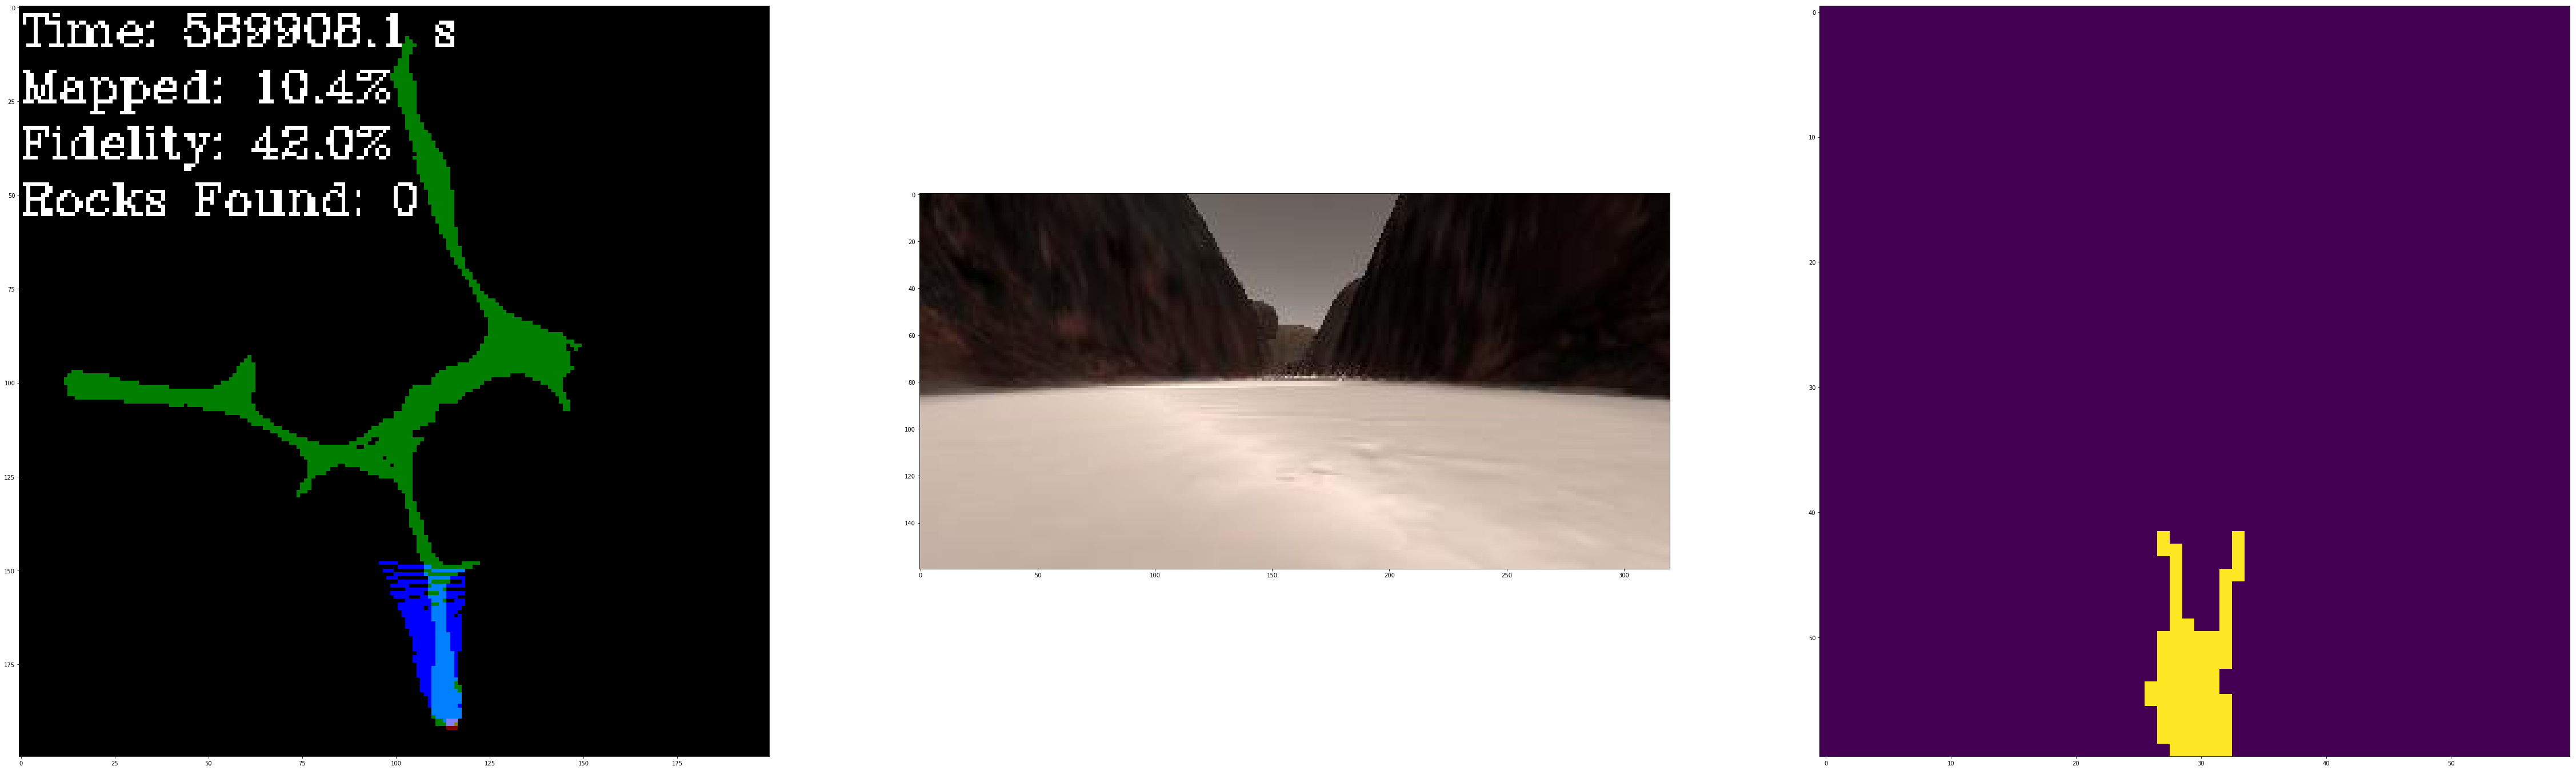

In [137]:
frame = low_fid_frames[0]
#frame = high_fid_frames[0]
print('roll and pitch error:', circle_distance(frame.metric['Roll'], 0), 
      circle_distance(frame.metric['Pitch'], 0))
print ('yaw =', frame.metric['Yaw'], 'pitch = ', frame.metric['Pitch'])
print('frame position:', frame.metric['X_Position'], frame.metric['Y_Position'])
fig = plt.figure(figsize=(80,160)) # Create a figure for plotting
mp = highlight_position(frame.frame, frame.metric['X_Position'], frame.metric['Y_Position'])
pitch = (frame.metric['Pitch'] / 180) * np.pi
SINGULAR = int(pcperspect.get_singular(pitch) * PIXEL_SCALING)
print(SINGULAR)
coords = convert_camera_coords(frame.frame)
particles = interpo.extract_particles(coords, singular=SINGULAR)
s_coords = pcperspect.particle_transform(pitch, particles)
#s_coords = cperspect.particle_transform(particles)
print('max x info:', particles[0, :].max(), s_coords[:, 0].max())
persp = render.render(s_coords)
plt.subplot(131)
plt.imshow(mp)
plt.subplot(132)
plt.imshow(frame.frame)
plt.subplot(133)
plt.imshow(persp)
plt.show()

In [101]:
print(singular)

0.0410224587071


In [56]:
particles.shape

(2, 259191)

In [67]:
s_coords[:, 0].max()

0.32225689252307016

In [66]:
particles[0, :].max()

0.039984375000000003

In [68]:
s_coords = cperspect.particle_transform(particles)

In [69]:
s_coords[:, 0].max()

41.807765004679794

In [90]:
s_coords = pcperspect.particle_transform((frame.metric['Pitch'] / 180) * np.pi, particles)

[[ 0.22027432  0.        ]
 [-0.00774633  0.21374336]] [[-0.02074355]
 [-0.01685651]]


In [92]:
s_coords[:, 0].max()

7.2085968727585215

In [78]:
print(cperspect._w)

[[-0.21238859  0.        ]
 [-0.0077488  -0.22471291]]


In [105]:
import cv2
import numpy as np


def zoom_in(img: np.ndarray, boundary, factor: np.ndarray):
  img = img[boundary[0]: boundary[1], :, :]
  factor = factor.flatten()
  shape = factor * img.shape[:2]
  return cv2.resize(img, (shape[1], shape[0]), fx=0, fy=0)


class StripwiseInterpolationOptimized(object):

  def __init__(self, view_singular, pixel_factor, extractor):

    self._pixel_factor = pixel_factor
    self._extractor = extractor
    self._adjust_parameter(view_singular)

  def _adjust_parameter(self, view_singular):
    # view_singular = view_singular - 10
    self._view_singular = view_singular

    lower_boundary = (0, int(view_singular * 0.8))

    strip_size = view_singular - lower_boundary[1]

    self._mid_factor, self._top_factor \
      = np.array([[6], [2]]), np.array([[32], [2]])

    self._boundary_factor = 2

    self._lower_boundary = lower_boundary

    strip_unit = int(strip_size / 2)
    lower = lower_boundary[1]

    self._mid_boundary = \
      (lower - strip_unit, lower + strip_unit)

    self._top_boundary = \
      (lower, lower + strip_unit * 2)
    

  def _extract_strip(self, coords, boundary, factor):
    strip = zoom_in(coords, boundary, factor)
    particles = self._extractor(strip)
    particles = particles / factor.astype('float32')
    particles[0, :] += boundary[0]
    particles /= self._pixel_factor
    return particles

  def extract_particles(self, coords: np.ndarray, singular=None):

    if singular is not None:
      self._adjust_parameter(singular)

    boundary = self._lower_boundary

    lower_particles = self._extractor(
      coords[boundary[0]: boundary[1], :, :])

    lower_particles = lower_particles / self._pixel_factor
    
    mid_particles = self._extract_strip(
      coords, self._mid_boundary, self._mid_factor)

    top_particles = self._extract_strip(
      coords, self._top_boundary, self._top_factor)

    return np.concatenate(
      [lower_particles, mid_particles, top_particles], axis=1)


In [134]:
import numpy as np


def perspective_denominator(e, pitch):

  pc, ps = np.cos(pitch), np.sin(pitch)
  ex, ey, ez = e

  w = np.array([[pc, 0]], dtype=np.float64)

  b = np.array([-ex * pc + ez * ps], dtype=np.float64)

  return w, b


def perspective_numerator(e, c, pitch):
  ex, ey, ez = e
  cx, cy, cz = c
  pc, ps = np.cos(pitch), np.sin(pitch)

  w = np.array([[ez + cx * pc - cz * ps, 0],
                [cy * pc - ey * pc, cz + ex * pc - ez * ps]])

  b = np.array([[(-cx * ex + cz * ez) * pc + (cz * ex + cx * ez) * ps],
                [-cz * ey - cy * ex * pc + cy * ez * ps]])

  return w, b


def generate_rotation(pitch):
  pc, ps = np.cos(pitch), np.sin(pitch)
  rp = np.array([[pc, 0, ps], [0, 1, 0], [-ps, 0, pc]], dtype=np.float64)
  return rp


class PitchCalibratedPerspectiveInference(object):
  def __init__(self, camera_pos, view_pos):
    self._e = view_pos
    self._c = camera_pos

  def get_singular(self, pitch):
    ex, ez = self._e[0], self._e[2]
    return ex - ez * np.tan(pitch)

  def particle_transform(self, pitch, particles):

    rot = generate_rotation(pitch)

    e, c = self._e, rot@self._c

    w, b = perspective_numerator(e, c, pitch)

    numerator = w @ particles + b
    print(w, b)

    w, b = perspective_denominator(e, pitch)

    denominator = w @ particles + b

    return (numerator / denominator).transpose()

class PerspectiveRender(object):

  def __init__(self, scale, resolution):

    self._scale = scale
    self._resolution = resolution

  def render(self, particles, inplace=False):
    particles = particles * self._scale
    particles[:, 1] *= -1
    particles[:, 1] += self._resolution / 2
    particles = np.around(particles).astype('uint32')
    particles[:, 0] = self._resolution - particles[:, 0]
    particles = particles.clip(0, self._resolution - 1)
    render = np.zeros([self._resolution, self._resolution], dtype=np.uint8)
    render[particles[:, 0], particles[:, 1]] += 1
    if inplace:
      plt.imshow(render)
      plt.show()
    return render

In [135]:
interpo = StripwiseInterpolationOptimized(
    SINGULAR_PIXEL, PIXEL_SCALING, 
    lambda x: np.array(color_thresh(x, (160, 160, 160), 'float32').nonzero()))
pcperspect = PitchCalibratedPerspectiveInference(CAMERA_POSITION, VIEW_POINT_POSITION)
render = PerspectiveRender(scale=1, resolution=60)